# Homework 4: robotic navigation

**Preamble**: You have built a robot for navigating in an indoor environment. The environments you consider have flat floors, so that the whole task is always two-dimensional. The robot has a sensing capability, as it can sense a location with respect to special beacons. You have given a robot to a friend, who uses it to map different interiors. To do the mapping, your friend places beacons at the perimeter of the interior, and then moves the robot through some trajectory.
Every so often the robot stops, uses its compass to align itself with the direction to the north and then tries to sense the location of the beacons (relative to the robot's current position). Typically, it manages to locate several closest beacons. Your friend has conducted three experiments in three different interiors. You need to recover the location of beacons and the locations of the robot (where the measurements have been taken). 
From each experiment you get four arrays of measurements: **'beacons', 'robots', 'x', 'y'**. It is interpreted as follows: while the robot is in the position number **'robots[i]'**, it senses the beacon number 'beacons(i)', and the beacon is displaced by **'x[i]'** and **'y[i]'** from the robot's position. For each robot position, the robot senses several beacons. This data should be sufficient to recover the positions of the robot and of the beacons (up to a global translation, that does not matter for the purposes of your friend). 

**Experiment one (task1.mat) - 1 point:** This is the simplest environment (a room with a simple shape), the robot sensor works well (although a certain amount of Gaussian noise is present). The reconstruction can be reduced to solving a simple least-squares problem. Hint: use linear least-squares. Avoid using the explicit inversion of matrix. Instead, use *numpy.linalg.lstsq* to solve equations. Note that *numpy.linalg.lstsq* might add a (small) regularization to the system. Try using inversion (*'numpy.linalg.inv'*) to see how the reconstruction performs without regularization.


In this case there are $224$ equations of the following type

$$\begin{bmatrix}
x_\text{beacons[i]} - x_\text{robots[i]}\\
y_\text{beacons[i]} - y_\text{robots[i]}
\end{bmatrix} = 
\begin{bmatrix}
x[i]\\
y[i]
\end{bmatrix}
$$

So we see that we can express these equations in matrix form

$$BR\cdot v= \left[
\begin{array}{c|c}
B & R & 0 & 0\\
\hline
0 & 0 &B & R
\end{array}
\right] \cdot v= \begin{bmatrix}
x[0] \\
\vdots\\
x[44]\\
y[0]\\
\vdots\\
y[44]
\end{bmatrix}$$

Where $B$ - $224\times 17$ matrix that consists only of $0,1$, $R$ - $224\times 28$ matrix that consists only of $0,-1$. Out coordinate variables from a vector $v = (\overline{x_\text{beacons}}, \overline{x_\text{robots}}, \overline{y_\text{beacons}}, \overline{y_\text{robots}})$ of size $90\times 1$. Hence, our residual function is

$$\left[
\begin{array}{c|c}
B & R & 0 & 0\\
\hline
0 & 0 & B & R
\end{array}
\right]\cdot v - \begin{bmatrix}
x[0] \\
\vdots\\
x[44]\\
y[0]\\
\vdots\\
y[44] = 0
\end{bmatrix}$$


In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

mat_contents = sio.loadmat('task1.mat')

beacons = mat_contents['beacons']
robots = mat_contents['robots']
x = mat_contents['x']
y = mat_contents['y']
num_facts = len(beacons)
r, b = max(robots)[0], max(beacons)[0]

In [3]:
def one_i_pos(i, n, value=1):
    x = [0.0]*n
    x[i] = value
    return x

# Linear least squares

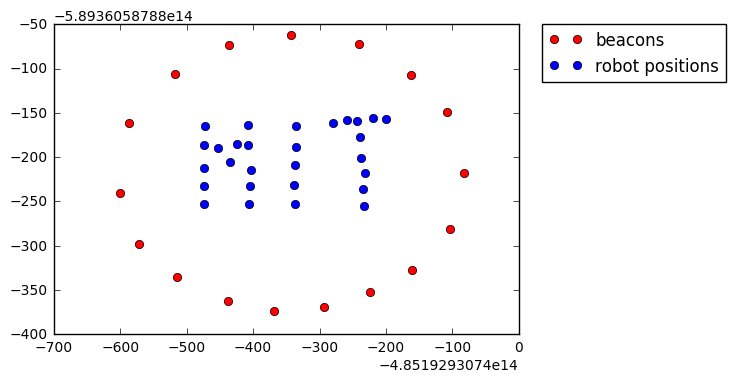

In [3]:
# Generating beacon matrix B
B = []
for i in range(num_facts):
    B.append(one_i_pos(beacons[i][0]-1, b))
B = np.array(B)

# Generating robot matrix R
R = []
for i in range(num_facts):
    R.append(one_i_pos(robots[i][0]-1, r))

R = -1 * np.array(R)

# Our matrix is concatenation of matrices B and R
F = np.concatenate((B,R), axis=1)


# Solving the system
x_solution = np.linalg.lstsq(F, x, rcond=-1)
y_solution = np.linalg.lstsq(F, y, rcond=-1)

# Plots
plt.plot(x_solution[0][:b], y_solution[0][:b], 'ro', color='red', label='beacons')
plt.plot(x_solution[0][b:], y_solution[0][b:], 'ro', color='blue', label='robot positions')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
# rob = fig.add_subplot(2,1,2)
# rob.plot(x_solution[0][(b+1):], y_solution[0][(b+1):], 'ro')
# rob.set_title('Robots positions')

# plt.tight_layout()
# fig.subplots_adjust(top=0.82)
# plt.show()

** Experiment two (task2.mat) - 4 points: ** This is a more complex environment. On top of that, there are strong electrical currents under the floor, so that the compass on the robot makes significant errors, so that the robot is not perfectly oriented. Thus, in addition to robot positions you would also need to recover robot orientations. *Hint and instructions:* you can still try to solve the problem as if the robot is perfectly oriented. You can then use what you obtain as an initialization to the non-linear initialization (angles can be initialized at zero). For the non-linear optimization, you should use non-linear least-squares. You can then either code Levenberg-Marquardt method yourself or figure out how to use *'scipy.optimize'*. In the latter case, to get the points, your final version must provide the python's routine with a Jacobian computed (analytically) by your code.


In [4]:
import scipy.io as sio
import scipy.optimize as so
from scipy.optimize import root

mat_contents = sio.loadmat('task2.mat')

beacons = mat_contents['beacons']
robots = mat_contents['robots']
x = mat_contents['x']
y = mat_contents['y']

num_facts = len(beacons)
r, b = max(robots)[0], max(beacons)[0]
l = 35

# Non-linear least squares

In this case there are $700$ equations of the following type


$$\begin{bmatrix}
x_\text{beacons[i]} - x_\text{robots[i]}\\
y_\text{beacons[i]} - y_\text{robots[i]}
\end{bmatrix}= 
\begin{bmatrix}
\cos(\alpha_\text{robots[i]}) && \sin(\alpha_\text{robots[i]})\\
-\sin(\alpha_\text{robots[i]}) && \cos(\alpha_\text{robots[i]})
\end{bmatrix}\cdot\begin{bmatrix}
x[i]\\
y[i]
\end{bmatrix}
$$

Hence, we have $700$ residuals functions of the following type

$$\begin{bmatrix}
f_i^1\\
f_i^2
\end{bmatrix} = \begin{bmatrix}
x_\text{beacons[i]} - x_\text{robots[i]}\\
y_\text{beacons[i]} - y_\text{robots[i]}
\end{bmatrix} - \begin{bmatrix}
\cos(\alpha_\text{robots[i]}) && \sin(\alpha_\text{robots[i]})\\
-\sin(\alpha_\text{robots[i]}) && \cos(\alpha_\text{robots[i]})
\end{bmatrix}\cdot\begin{bmatrix}
x[i]\\
y[i]
\end{bmatrix} = \begin{bmatrix}
x_\text{beacons[i]} - x_\text{robots[i]} - \cos(\alpha_\text{robots[i]})\cdot x[i] - \sin(\alpha_\text{robots[i]})\cdot y[i]\\
y_\text{beacons[i]} - y_\text{robots[i]} + \sin(\alpha_\text{robots[i]})\cdot x[i] - \cos(\alpha_\text{robots[i]})\cdot y[i]
\end{bmatrix}$$

Our variables contain in vector $(\overline{\alpha}, \overline{x_\text{beacons}},  \overline{y_\text{beacons}}, \overline{x_\text{robots}},  \overline{y_\text{robots}})$

## Firstly, we solve linear least squares problem

The solution of linear least squares problem we can use for initial guess. We use the code from the previous problem.

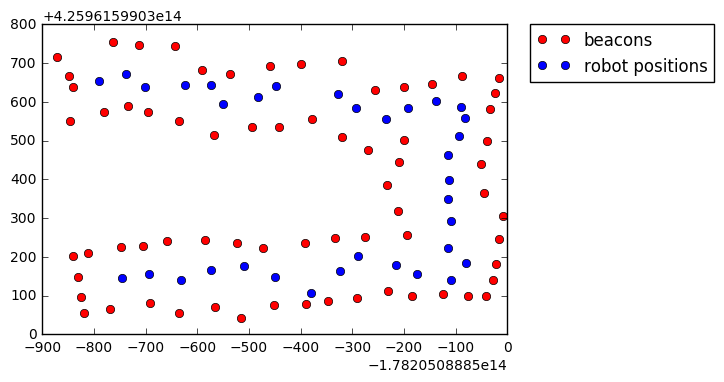

In [5]:
# Generating beacon matrix
B = []
for i in range(num_facts):
    B.append(one_i_pos(beacons[i][0]-1, b))
    
B = np.array(B)
# Generating robot matrix
R = []
for i in range(num_facts):
    R.append(one_i_pos(robots[i][0]-1, r))

R = -1 * np.array(R)

# Our matrix is concatenation of matrices B and R
F = np.concatenate((B,R), axis=1)


# constrx = np.identity(104)[0].reshape(1, 104)
# constry = np.identity(104)[69].reshape(1, 104)
# F_tildex = np.concatenate((F,constrx), axis=0)
# x_tilde = np.concatenate((x, np.zeros((1,1))), axis=0)
# F_tildey = np.concatenate((F,constry), axis=0)
# y_tilde = np.concatenate((y, np.zeros((1,1))), axis=0)
# Solving the system

x_solution = np.linalg.lstsq(F, x, rcond=-1)
y_solution = np.linalg.lstsq(F, y, rcond=-1)

# Plots
plt.plot(x_solution[0][:b], y_solution[0][:b], 'ro', color='red', label='beacons')
plt.plot(x_solution[0][(b+1):], y_solution[0][(b+1):], 'ro', color='blue', label='robot positions')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

Save the solution.

In [6]:
# Solve linear regression problem for initial guess for non-linear problem
initial = np.concatenate((x_solution[0],y_solution[0]), axis=0).reshape(1,208)[0]
initial = np.concatenate((np.zeros(35), initial))

Here is code for the residual function.

In [18]:
def residual(all_variables):
    
    # Cutting initial guess to 5 arrays of x,y coordinates of beacons and robot positions and angles values
    alpha = all_variables[:r]
    coordinates = all_variables[r:]
    
    robots_coordinates = coordinates[:2*r]   #  r:3r
    beacons_coordinates = coordinates[2*r:]  #  3r:
    
    robots_x = robots_coordinates[:r]        #  r:2r
    robots_y = robots_coordinates[r:]        #  2r:3r
    
    beacons_x = beacons_coordinates[:b]      #  3r:3r+b
    beacons_y = beacons_coordinates[b:]      #  3r+b:
    
    # Generating residual array
    residuals = []
    for i in range(num_facts):
        x_res = beacons_x[beacons[i]-1] - robots_x[robots[i]-1] - np.cos(alpha[robots[i]-1]) * x[i][0] - np.sin(alpha[robots[i]-1]) * y[i][0]
        y_res = beacons_y[beacons[i]-1] - robots_y[robots[i]-1] + np.sin(alpha[robots[i]-1]) * x[i][0] - np.cos(alpha[robots[i]-1]) * y[i][0]
        residuals.append(x_res)
        residuals.append(y_res)
   
    residuals = np.array(residuals)
    residuals = residuals.reshape(1, 2 * num_facts)[0]
    # print 'Residual =' , np.linalg.norm(residuals)
    return residuals

In [8]:
def values_on_ind(x, y, n=243):
    result = [0] * n
    j = 0
    for i in x:
        result[i] = y[j]
        j += 1
    return result

Jacobian is $700\times 243$ matrix. In each row we have only three non zero elements: derivative w.r.t $1$ coordinate of beacon (this derivative is alwayas equal to $1$), derivative w.r.t $1$ coordinate of robot(this derivative is always equal to $-1$) and derivative w.r.t $\alpha$. For example


$$\frac{\partial f_i^1}{\partial x_\text{beacons[i]}} = 1$$
$$\frac{\partial f_i^1}{\partial x_\text{robots[i]}} = -1$$
$$\frac{\partial f_i^1}{\partial \alpha_\text{robots[i]}} = \sin(\alpha_\text{robots[i]})\cdot x[i] - \cos(\alpha_\text{robots[i]})\cdot y[i]$$

In [9]:
def jacobian(all_variables):
    jac = []
    alpha = all_variables[:35]
    for i in range(num_facts):
        
        # Value of derivative w.r.t alpha
        alpha_der_value1 = (np.sin(alpha[robots[i]-1]) * x[i][0] - np.cos(alpha[robots[i]-1]) * y[i][0])[0]
        
        # Indicies of non-zero elements
        alpha_ind = (robots[i] - 1)[0]
        x_b_ind = 3 * r + (beacons[i] - 1)[0]
        x_r_ind = r + (robots[i] - 1)[0]
        
        derivative1 = values_on_ind([alpha_ind, x_b_ind, x_r_ind], [alpha_der_value1, 1, -1])
        jac.append(derivative1) 
        
        # Value of derivative w.r.t alpha
        alpha_der_value2 = (np.cos(alpha[robots[i]-1]) * x[i][0] + np.sin(alpha[robots[i]-1]) * y[i][0])[0]
        
        # Indicies
        y_b_ind = 3 * r + b + (beacons[i] - 1)[0]
        y_r_ind = 2 * r + (robots[i] - 1)[0]
        
        derivative2 = values_on_ind([alpha_ind, y_b_ind, y_r_ind], [alpha_der_value2, 1, -1])
        jac.append(derivative2)
    
    
    jac = np.array(jac)
    return jac

## Now we solve non linear least squares problem

In [10]:
sol1 = so.least_squares(residual, np.zeros(243), method='lm', jac=jacobian)

Residual = 2430.1627889
Residual = 2430.1627889
Residual = 2430.1627889
Residual = 2276.99566566
Residual = 2007.60870106
Residual = 1605.50132826
Residual = 1103.75401071
Residual = 252.417943319
Residual = 182.112717035
Residual = 177.083607021
Residual = 177.028457103
Residual = 177.025276989
Residual = 177.025070747
Residual = 177.025057153
Residual = 177.025056256
Residual = 177.025056197


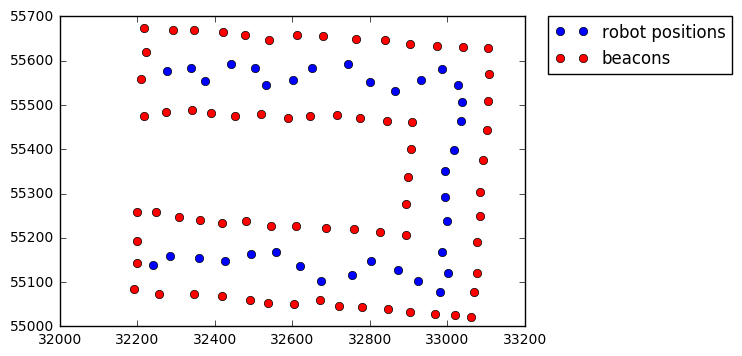

In [11]:
plt.plot(sol1.x[35:70], sol1.x[70:105], 'ro', color='blue', label='robot positions')
plt.plot(sol1.x[105:174], sol1.x[174:], 'ro', color='red', label='beacons')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

**Yeah!** With jacobian result is a little bit worse, but much more faster :)

** Experiment three (task3.mat) - 6 points: **  This is another complex environment. On top of the complications from the previous experiment, your robot beacon identification system is now working imperfectly, so that every so often (say, in 3% cases), the robot would confuse the number of the beacon that it observes. You have to make your reconstruction algorithm robust to such mistakes.  Instruction: use non-linear optimization *scipy.optimize* in python (you get 2 points for any implementation that produces an accurate reconstruction). You are recommended to supply it with an analytically-computed gradient (+2 points). Use the option 'method=BFGS' to make python to use a quasi-Newton BFGS method, play with the number of iterations that are allowed ('options.maxiter') to see the effect; you can also try to provide the algorithm with the Hessian derived analytically. You get +2 points if your approach devised this way will work faster or comparable with quasi-Newton. 

**Output.** For each experiment, your pdf file should include:
*	A printout of the reconstruction: use e.g. scatter plots with different colors used for beacons and robots positions.
*	An explanation of what you have tried and what you have observed.
Of course, your code should be attached.


In [5]:
import scipy.io as sio
import numpy as np

mat_contents = sio.loadmat('task3.mat')

beacons = mat_contents['beacons']
robots = mat_contents['robots']
x = mat_contents['x']
y = mat_contents['y']

num_facts = len(beacons)
r, b = max(robots)[0], max(beacons)[0]

# Linear least squares

In [6]:
# Generating beacon matrix
B = []
for i in range(num_facts):
    B.append(one_i_pos(beacons[i][0]-1, b))
    
B = np.array(B)
# Generating robot matrix
R = []
for i in range(num_facts):
    R.append(one_i_pos(robots[i][0]-1, r))

R = -1 * np.array(R)

# Our matrix is concatenation of matrices B and R
F = np.concatenate((B,R), axis=1)

x_solution = np.linalg.lstsq(F, x, rcond=-1)
y_solution = np.linalg.lstsq(F, y, rcond=-1)

print x_solution[0].shape
# Plots
plt.plot(x_solution[0][:b], y_solution[0][:b], 'ro', color='red', label='beacons')
plt.plot(x_solution[0][(b+1):], y_solution[0][(b+1):], 'ro', color='blue', label='robot positions')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

(106L, 1L)


NameError: name 'plt' is not defined

In [32]:
initial = np.concatenate((x_solution[0],y_solution[0]), axis=0).reshape(1,212)[0]
initial = np.concatenate((np.zeros(r), initial))

## Non linear least squares

In [33]:
sol2 = so.least_squares(residual, initial, method='trf', loss='huber', ftol=1e-03)

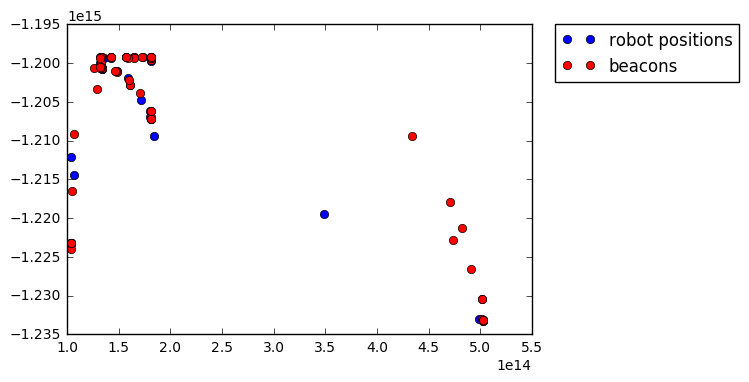

In [34]:
plt.plot(sol2.x[r:2*r], sol2.x[2*r:3*r], 'ro', color='blue', label='robot positions')
plt.plot(sol2.x[3*r:3*r+b], sol2.x[3*r+b:], 'ro', color='red', label='beacons')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()